# Tutorial 04
## Balancing and binning

The theoretical background is explained in Lecture 7. CNN and ENN can be found in Lecture 6.

### Balancing

Problem: We have an instance of some classification problem and our data set is imbalanced, that is, one class has _significantly_ less representants than another class.

A model trained on such a dataset can be heavily biased towards the overrepresented class.

Obecne sou 2 pristupy: oversampling a undersampling

In [1]:
# disable autoscrolling

In [2]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# import libraries

import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, confusion_matrix, accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

import itertools
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline

In [4]:
RANDOM_STATE = 42

### The data

In [5]:
# binary classification of default payment (-> credible or not credible clients)
data = pd.read_csv('default_of_credit_card_clients.csv',sep=';') 
# source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  class   300

In [6]:
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
# X4: Marital status (1 = married; 2 = single; 3 = others). 

# based on data description missing values can be indentified as '0'
data[['X3', 'X4']].describe()

,X3,X4
count,30000.000000,30000.000000
mean,1.853133,1.551867
std,0.790349,0.521970
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,6.000000,3.000000


In [7]:
# dafault payment? -> 1 = Yes, 0 = No
data['class'].value_counts()

0    23364
1     6636
Name: class, dtype: int64

## (Binary) classification and its evaluation

In order to evaluate the preprocessing of our data set, we shall use some classifiers as black boxes.

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


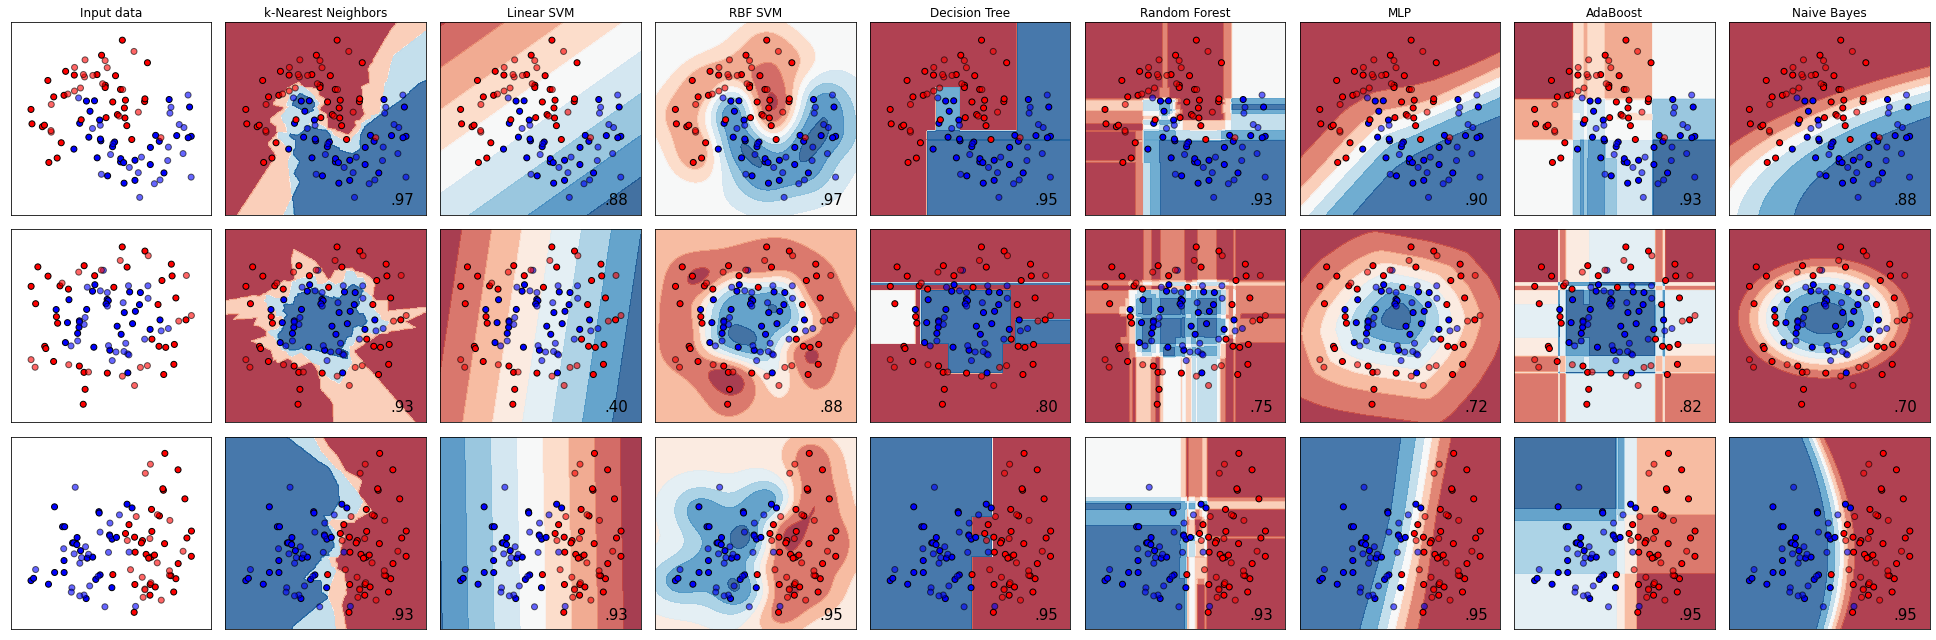

In [8]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# code taken from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

h = .02  # step size in the mesh

names = ["k-Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "MLP", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1), 
    DecisionTreeClassifier(max_depth=5), # gini criterion
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

The following metrics are commonly used to evaluate the performance of a **binary** classifier (and the underlying data set).

There are 2 classes, positive and negative. The counts of their representants are denoted $P$ and $N$, respectively.
The results of the classification are given by the following counts:
$$
TP = \text{true positive}, TN = \text{true negative}, FP = \text{false positive}, TN = \text{false negative}.
$$
(That is, $TP+FP$ samples are assigned the positive class by the selected classifier.)

These number are ofter stored in _confusion matrix_ (in Czech often "klasifikační matice" or "matice záměn"):
$$
C = \begin{pmatrix} TN & FN \\ FP & TP \end{pmatrix}.
$$


(In multiple class problem, these metrics are generalized in a straightforward manner, see for instance http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

<img src="confusion_matrix.png">

Source: www.info.univ-angers.fr

Let's calculate the confusion matrix by http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html.

In [9]:
# split data
y = list(data['class'])
X = data.drop(['class'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(18000, 23) (12000, 23)


In [10]:
# select a classifier above and classify `data` 
# and calculate the confusion matrix of the result

#clf = GaussianNB()
#clf = SVC(gamma=2, C=1) # depends on C, can be tuned by https://scikit-learn.org/stable/modules/grid_search.html
#clf = SVC(kernel="linear", C=0.025)
clf = DecisionTreeClassifier()

y_pred = clf.fit(X_train, y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred) # check the order -> (y_true, y_pred) 

print(cnf_matrix)

[[7523 1834]
 [1536 1107]]


Let's plot the confusion matrix (to have some fancy visualisation ...).

In [11]:
# code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

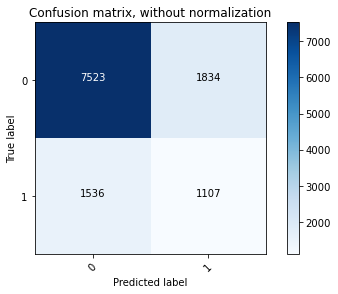

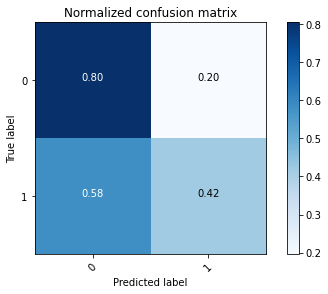

In [12]:
np.set_printoptions(precision=2)
class_names = [0,1] # for printing purposes only

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

From the confusion matrix one can compute:

- **True positive rate (TPR)** also known as sensitivity or recall or hit rate,
$$
\text{TPR} = \frac{TP}{TP+FN}.
$$
- **False positive rate (FPR)** also known as false alarm rate or type I error rate,
$$
\text{FPR} = \frac{FP}{FP+TN}.
$$
- **False negative rate (FNR)** also known as miss rate or type II error rate,
$$
\text{FNR} = \frac{FN}{TP+FN}.
$$
- **True negative rate (TNR)** also known as specificity or selectivity,
$$
\text{TNR} = \frac{TN}{FP+TN}.
$$


Other important performance measures derivable from the confusion matrix and very often used is the **accuracy**:
$$
 \text{ACC} = \frac{TP+TN}{P+N},
$$
and **F1-score** (harmonic mean of precision and recall):
$$
\text{F1-score} = \frac{2}{1/PPV + 1/TPR},
$$
where PPV stands for **precision**:
$$
\text{PPV} = \frac{TP}{TP+FP}.
$$

Especially F1-score is useful in highly unbalanced datasets.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [13]:
print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.7191666666666666 
F1-score:  0.39648997134670483


## Handling imbalanced classes

(We still focus on the binary class problem.)

The class with the majority of samples is called the **majority class**, the other is the **minority class**.

The basic strategies are
1. to under-sample the majority class (= to remove some its elements)
1. to over-sample the minority class (= to add some elements to the class)
1. do both of the above
1. do nothing


## ulozim si puvodni precision a acurr a po provedeni zmen budu porovnavat
acc 71%, F1 39% origin data

### Under-sampling

#### Imbalanced-learn

https://imbalanced-learn.org/stable/

`pip/pip3 install imbalanced-learn --user [--upgrade]`


Counter({0: 3993, 1: 3993})


<Figure size 432x288 with 0 Axes>

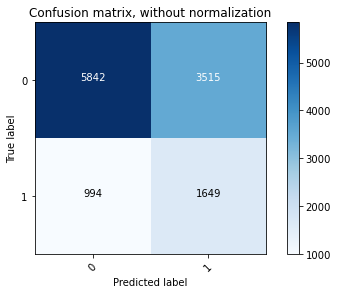

<Figure size 432x288 with 0 Axes>

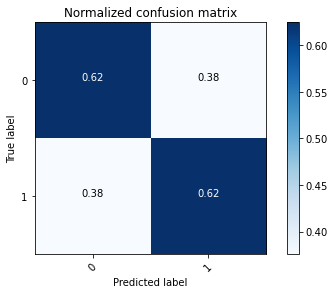

Accuracy:  0.62425 
F1-score:  0.42244139874471626


In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_STATE)

X_res, y_res = rus.fit_sample(X_train, y_train)

print(Counter(y_res)) # dictionary

y_pred = clf.fit(X_res, y_res).predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

## Under-sampling methods

- Random under-sampling
- (Wilson's) Edited Nearest Neighbor (ENN)
- Condensed Nearest Neighbor (CNN)
- One-side Sampling (OSS)
- Neighborhood Cleaning Rule (NCL) 
- Tomek Links

https://imbalanced-learn.org/stable/under_sampling.html

#### Tomek links

Let $x$ and $y$ be two samples of distinct class.
If there is no sample $z$ such that
$$
\rm{d}(x, z) < \rm{d}(x, y) \quad \text{ or } \quad \rm{d}(y, z) < \rm{d}(x, y),
$$
where $\rm d$ is **the distance** between the two samples, we say there is a **Tomek link** between $x$ and $y$.

In other words, a Tomek’s link exists if the two samples of distinct class are the nearest neighbors of each other.
See the illustration at https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#tomek-links

We can choose various strategies how to resample the data using Tomek links, for instance, we might remove all majority samples which are paired by the link with a minority sample.

Counter({0: 10000, 1: 500})
No sampling method applied


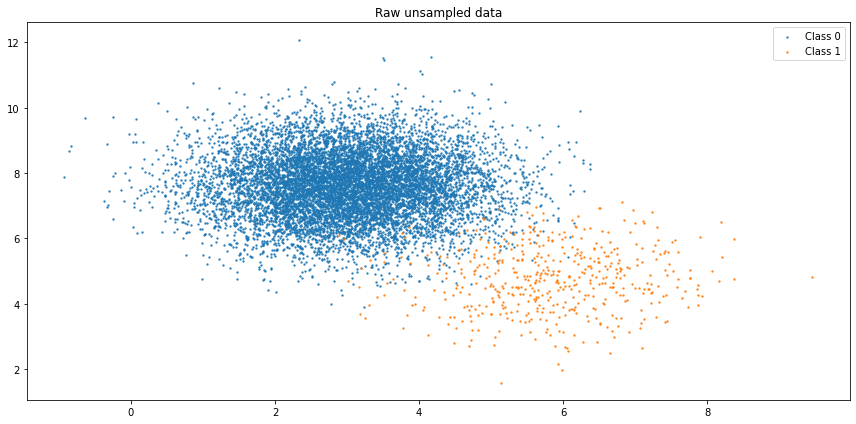

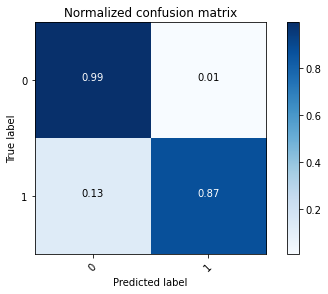

Accuracy:  0.9880952380952381 
F1-score:  0.8768472906403942

**************************************************
Under-sampling using random under-sampler
Counter({0: 296, 1: 296})


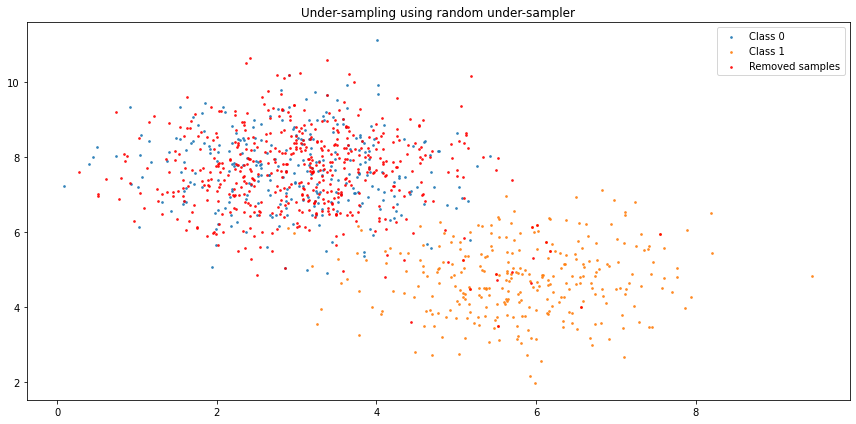

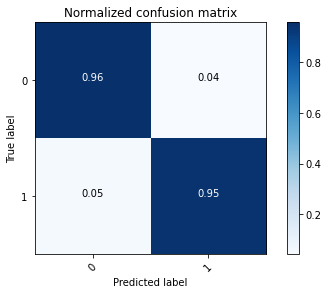

Accuracy:  0.9564285714285714 
F1-score:  0.6783831282952549

**************************************************
Under-sampling using Tomek Links
Counter({0: 5980, 1: 296})


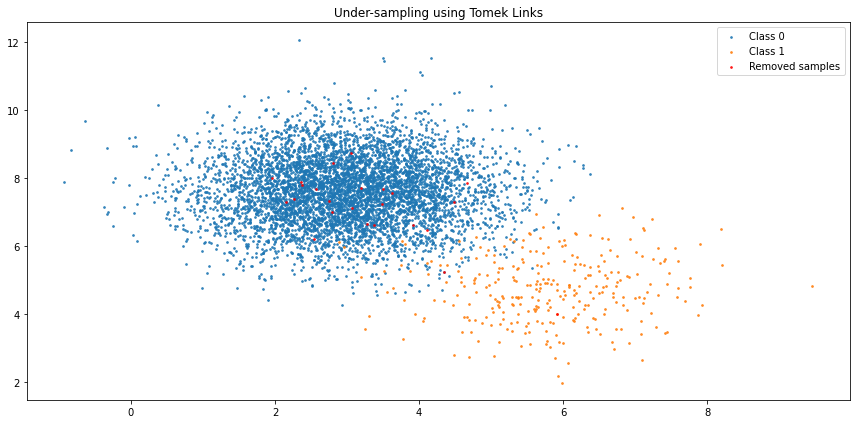

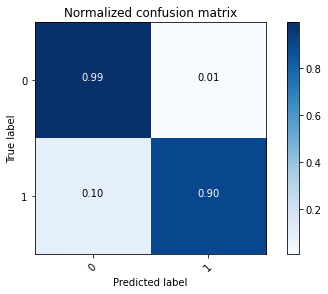

Accuracy:  0.9885714285714285 
F1-score:  0.8846153846153846


In [15]:
# example with 2D data

from imblearn.under_sampling import TomekLinks
from numpy import where

# generate blob data
X_exm, y_exm = make_blobs(n_samples=[10000, 500], n_features=2, center_box=(0, 8), random_state=RANDOM_STATE)

X_train_exm, X_test_exm, y_train_exm, y_test_exm = train_test_split(X_exm, y_exm, test_size=.4, random_state=RANDOM_STATE)

print(Counter(y_exm))

#clf = GaussianNB()
#clf = SVC(gamma=2, C=1)
#clf = SVC(kernel="linear", C=0.025)
clf = DecisionTreeClassifier()

print('No sampling method applied')

idx_class_0 = y_exm == 0
_size = 2

plt.figure(figsize=(12, 6))
plt.scatter(X_exm[idx_class_0, 0], X_exm[idx_class_0, 1],
            alpha=.8, s=_size, label='Class 0')
plt.scatter(X_exm[~idx_class_0, 0], X_exm[~idx_class_0, 1],
            alpha=.8, s=_size, label='Class 1')

plt.title('Raw unsampled data')
plt.legend()
plt.tight_layout()
plt.show()

# no sampling method applied
y_pred = clf.fit(X_train_exm, y_train_exm).predict(X_test_exm)
cnf_matrix = confusion_matrix(y_test_exm, y_pred)

# Plot normalized confusion matrix   
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test_exm, y_pred),'\nF1-score: ', f1_score(y_test_exm, y_pred))


###################################
# Apply the random under-sampler

print('\n**************************************************')
print('Under-sampling using random under-sampler')

rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = rus.fit_sample(X_train_exm, y_train_exm)
idx_resampled = rus.sample_indices_

print(Counter(y_resampled))

idx_samples_removed = np.setdiff1d(np.arange(X_resampled.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

plt.figure(figsize=(12, 6))
plt.scatter(X_resampled[idx_class_0, 0], X_resampled[idx_class_0, 1],
            alpha=.8, s=_size, label='Class 0')
plt.scatter(X_resampled[~idx_class_0, 0], X_resampled[~idx_class_0, 1],
            alpha=.8, s=_size, label='Class 1')
plt.scatter(X_exm[idx_samples_removed, 0], X_exm[idx_samples_removed, 1],
            alpha=.8, s=_size, label='Removed samples', color='red')

plt.title('Under-sampling using random under-sampler')
plt.legend()
plt.tight_layout()
plt.show()

# classify
y_pred = clf.fit(X_resampled, y_resampled).predict(X_test_exm)
cnf_matrix = confusion_matrix(y_test_exm, y_pred)

# Plot normalized confusion matrix   
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test_exm, y_pred),'\nF1-score: ', f1_score(y_test_exm, y_pred))


###################################
# Apply the Tomek Link under-sampler

print('\n**************************************************')
print('Under-sampling using Tomek Links')

tl = TomekLinks(sampling_strategy='not minority') # default - will remove the sample from the majority class
X_resampled, y_resampled = tl.fit_sample(X_train_exm, y_train_exm)
idx_resampled = tl.sample_indices_

print(Counter(y_resampled))

idx_samples_removed = np.setdiff1d(np.arange(X_resampled.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

plt.figure(figsize=(12, 6))
plt.scatter(X_resampled[idx_class_0, 0], X_resampled[idx_class_0, 1],
            alpha=.8, s=_size, label='Class 0')
plt.scatter(X_resampled[~idx_class_0, 0], X_resampled[~idx_class_0, 1],
            alpha=.8, s=_size, label='Class 1')
plt.scatter(X_exm[idx_samples_removed, 0], X_exm[idx_samples_removed, 1],
            alpha=.8, s=_size, label='Removed samples', color='red')

plt.title('Under-sampling using Tomek Links')
plt.legend()
plt.tight_layout()
plt.show()

# clsssify
y_pred = clf.fit(X_resampled, y_resampled).predict(X_test_exm)
cnf_matrix = confusion_matrix(y_test_exm, y_pred)

# Plot normalized confusion matrix   
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test_exm, y_pred),'\nF1-score: ', f1_score(y_test_exm, y_pred))

### Over-sampling methods

- random over-sampling
- Synthetic Minority Over-sampling Technique (SMOTE)
- data augmentation by GANs etc.

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

#### SMOTE

SMOTE inserts new samples based on the following idea: having selected a sample $x$ from the minority class, find its $k$ nearest neighbors, connect them and $x$ by a line, and then pick new samples randomly on each line.

<img src="smote.png">

##### Mathematical formulation
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#mathematical-formulation

<!--
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py
-->

No sampling method applied
Counter({0: 14007, 1: 3993})


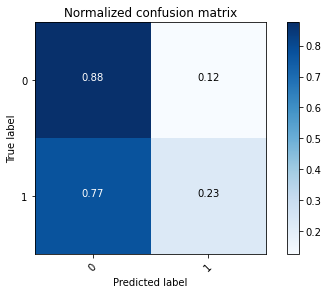

Accuracy:  0.7321666666666666 
F1-score:  0.27087114337568063

************************************************************
Random under-sampling
Wall time: 32 ms
Counter({0: 3993, 1: 3993})


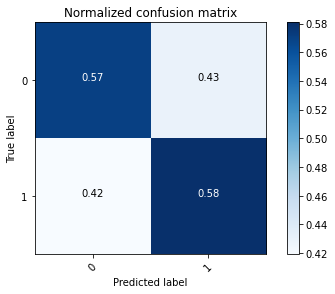

Accuracy:  0.5725 
F1-score:  0.374390243902439

************************************************************
Tomek Links
Wall time: 2.04 s
Counter({0: 12964, 1: 3993})


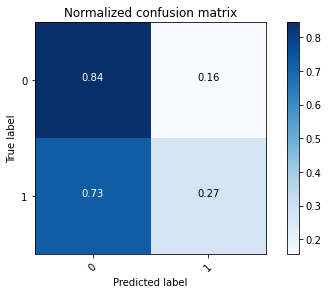

Accuracy:  0.71875 
F1-score:  0.3008079552517091

************************************************************
Edited NN
Wall time: 2.11 s
Counter({0: 7589, 1: 3993})


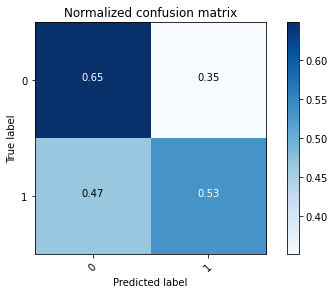

Accuracy:  0.6230833333333333 
F1-score:  0.3838714071652363

************************************************************
One Sided Selection
Wall time: 3.11 s
Counter({0: 12958, 1: 3993})


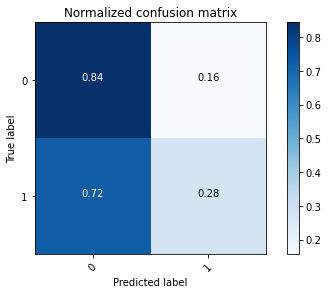

Accuracy:  0.7180833333333333 
F1-score:  0.3011774426771328

************************************************************
Random over-sampling
Wall time: 54 ms
Counter({0: 14007, 1: 14007})


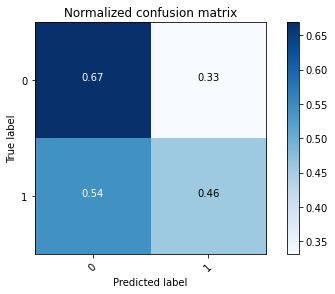

Accuracy:  0.6221666666666666 
F1-score:  0.3474381116868163

************************************************************
SMOTE
Wall time: 243 ms
Counter({0: 14007, 1: 14007})


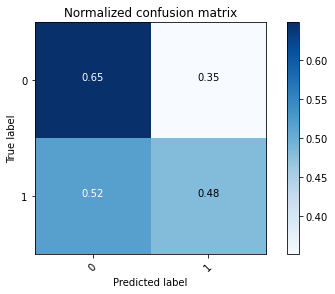

Accuracy:  0.6118333333333333 
F1-score:  0.35377358490566047

************************************************************
SMOTEENN
Wall time: 4.91 s
Counter({1: 10063, 0: 6179})


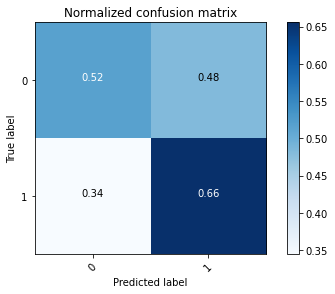

Accuracy:  0.548 
F1-score:  0.38987626546681664


In [16]:
# various under and over-sampling methods on data

from imblearn.under_sampling import CondensedNearestNeighbour
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# zde moznost si pohrat s klasifikatorem
#clf = GaussianNB()
#clf = DecisionTreeClassifier()
#clf = BernoulliNB()
clf = KNeighborsClassifier(3)

resamplers = [
    (RandomUnderSampler(random_state=RANDOM_STATE),'Random under-sampling'),
    (TomekLinks(),'Tomek Links'),
    #(CondensedNearestNeighbour(random_state=RANDOM_STATE),'Condensed NN'), # this takes ages
    (EditedNearestNeighbours(),'Edited NN'),
    (OneSidedSelection(random_state=RANDOM_STATE),'One Sided Selection'),
    (RandomOverSampler(random_state=RANDOM_STATE),'Random over-sampling'),
    (SMOTE(random_state=RANDOM_STATE),'SMOTE'),
    (SMOTEENN(random_state=RANDOM_STATE),'SMOTEENN'),  
]

# no sampling method applied
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print('No sampling method applied')
print(Counter(y_train))
# Plot normalized confusion matrix   
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

# let's introduce various sampling methods
for resampler,description in resamplers:
    print('\n************************************************************')
    print(description)
    %time X_res, y_res = resampler.fit_sample(X_train, y_train)
    print(Counter(y_res))

    y_pred = clf.fit(X_res, y_res).predict(X_test)   
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     plot_confusion_matrix(cnf_matrix, classes=class_names,
#                           title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix   
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

## Binning

Binning is a very **common discretization technique**:
1. select bins $B_i$ covering (disjointly) the range of a feature $x$
1. create the discretized feature with the value $v_i$ if $x \in B_i$

Usual choices of the bins:
1. equal width (the bins have the same size) - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
1. equal depth/frequency (the bins contain the same number of elements) - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html

Also you can find some in scikit-learn as [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer).

Equal width and equal depth binnings are unsupervised methods, i.e. the choice of bins does not depend on target feature. Compared to that supervised binning methods take into account the target feature when selecting discretization cut points. E.g. entropy-based binning or advanced minimum description length principle ([MDLP](https://github.com/maxpumperla/entropy-mdlp)) algorithm based on [Fayyad, U., & Irani, K. (1993). Multi-interval discretization of continuous-valued attributes for classification learning](https://www.ijcai.org/Proceedings/93-2/Papers/022.pdf).

,Age
count,30000.000000
mean,35.485500
std,9.217904
min,21.000000
25%,28.000000
50%,34.000000
75%,41.000000
max,79.000000


<AxesSubplot:>

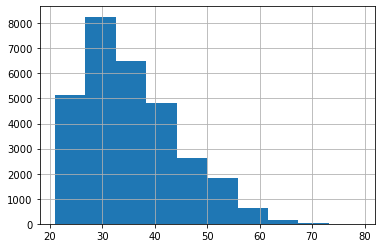

In [17]:
# let's discretize feature X5 (Age (year))
data = data.rename({'X5': 'Age'}, axis=1) 
display(data[['Age']].describe())
data.Age.hist()

<AxesSubplot:>

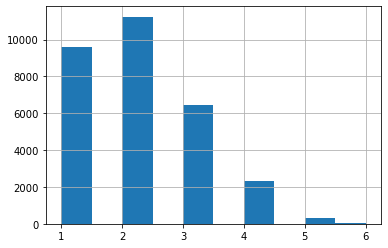

In [18]:
# we can do it in a hand - neni uplne nej to delat rucne

data['AgeBin'] = 0 # create a column of 0
data.loc[((data['Age'] > 20) & (data['Age'] < 30)) , 'AgeBin'] = 1
data.loc[((data['Age'] >= 30) & (data['Age'] < 40)) , 'AgeBin'] = 2
data.loc[((data['Age'] >= 40) & (data['Age'] < 50)) , 'AgeBin'] = 3
data.loc[((data['Age'] >= 50) & (data['Age'] < 60)) , 'AgeBin'] = 4
data.loc[((data['Age'] >= 60) & (data['Age'] < 70)) , 'AgeBin'] = 5
data.loc[((data['Age'] >= 70) & (data['Age'] < 81)) , 'AgeBin'] = 6
data.AgeBin.hist()

2    11238
1     9618
3     6464
4     2341
5      314
6       25
Name: AgeBin2, dtype: int64

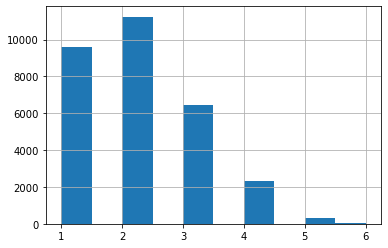

In [19]:
# example of bins with equal width

bins = [20, 29, 39, 49, 59, 69, 81]
bins_names = [1, 2, 3, 4, 5, 6]
data['AgeBin2'] = pd.cut(data['Age'], bins, labels=bins_names)
data.AgeBin2.hist()
data.AgeBin2.value_counts()

## Zde jiz nedelame rucne, upravy by tedy meli byt aplikovany pouze na trenovaci mnozine a pak vyzkouseny na testovaci!
V kodu to udelano neni, **POZOR** na to!!

In [20]:
# stejny zpusob akorat nemusime definovat biny rucne
data['AgeBin3'] = pd.cut(data['Age'], 6) # bins = 6
data.AgeBin3.value_counts()

(20.942, 30.667]    11013
(30.667, 40.333]    10713
(40.333, 50.0]       6005
(50.0, 59.667]       1930
(59.667, 69.333]      314
(69.333, 79.0]         25
Name: AgeBin3, dtype: int64

<AxesSubplot:>

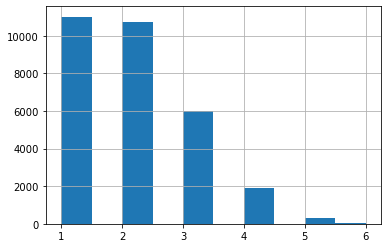

In [21]:
data['AgeBin3'] = pd.cut(data['Age'], 6, labels=bins_names)
data.AgeBin3.hist()

2    5886
4    5160
1    5127
3    4683
6    4669
5    4475
Name: AgeBin4, dtype: int64

[21. 26. 30. 34. 39. 45. 79.]


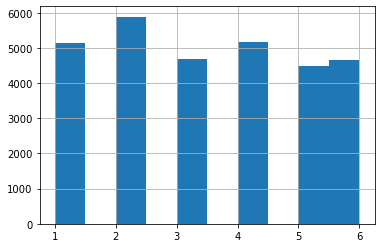

In [22]:
# example of bins with equal depth

data['AgeBin4'], bins = pd.qcut(data['Age'], 6, labels=bins_names, retbins=True)
data.AgeBin4.hist()
display(data.AgeBin4.value_counts())
print(bins)

In [23]:
data.head()

,X1,X2,X3,X4,Age,X6,X7,X8,X9,X10,...,X19,X20,X21,X22,X23,class,AgeBin,AgeBin2,AgeBin3,AgeBin4
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,1,1,1,1,1
1,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,1,1,1,1,1
2,90000,2,2,2,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,2,2,2,3
3,50000,2,2,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,2,2,2,4
4,50000,1,2,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,4,4,4,6


In [24]:
# compare discretization (AgeBin3, AgeBin4) by classification model
clf = DecisionTreeClassifier()

# Age - original data
y = list(data['class'])
X = data.drop(['class', 'AgeBin', 'AgeBin2', 'AgeBin3', 'AgeBin4'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print('\nOriginal data \nAccuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

# AgeBin3
X = data.drop(['class', 'Age', 'AgeBin', 'AgeBin2', 'AgeBin4'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print('\nBins with equal width \nAccuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

# AgeBin4
X = data.drop(['class', 'Age', 'AgeBin', 'AgeBin2', 'AgeBin3'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print('\nBins with equal depth \nAccuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))



Original data 
Accuracy:  0.71875 
F1-score:  0.39309476712821434

Bins with equal width 
Accuracy:  0.7194166666666667 
F1-score:  0.39605381165919284

Bins with equal depth 
Accuracy:  0.7235 
F1-score:  0.3980406386066763


Note, there is a cute mistake in this process (methodical one). Can you find it?

### Some References

1. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
1. https://svds.com/learning-imbalanced-classes/
1. [Tomas Borovicka, Marcel Jirina Jr., Pavel Kordik and Marcel Jirina, _Selecting Representative Data Sets_](https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/selecting-representative-data-sets)
1. [Vuk, Curk: _ROC Curve, Lift Chart and Calibration Plot_](http://www.stat.wvu.edu/~jharner/courses/dsci503/docs/vuk.pdf)
1. [Elhassan T, Aljurf M, Al-Mohanna F, and Shoukri M:_Classification of Imbalance Data using Tomek Link (T-Link) Combined with Random Under-sampling (RUS) as a Data Reduction Method_](https://pdfs.semanticscholar.org/6ec4/18f9071f3a96d5548e87e34be3665703119e.pdf?_ga=2.37521248.1702047165.1541793547-736740435.1531120151)